In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

import skbeam.core.correlation as corr
import skbeam.core.roi as roi
import skbeam.core.utils as utils

from multiprocessing import Pool, Process, Queue
import multiprocessing
import time as ttime

from __future__ import absolute_import, division, print_function
from collections import namedtuple
import numpy as np


import logging
logger = logging.getLogger(__name__)

results = namedtuple(
    'correlation_results',
    ['g2', 'lag_steps', 'internal_state']
)

_internal_state = namedtuple(
    'correlation_state',
    ['buf',
     'G',
     'past_intensity',
     'future_intensity',
     'img_per_level',
     'label_array',
     'track_level',
     'cur',
     'pixel_list',
     'num_pixels',
     'lag_steps',
     'norm',
     'lev_len']
)


def _init_state_one_time(num_levels, num_bufs, labels):
    """Initialize a stateful namedtuple for the generator-based multi-tau
     for one time correlation

    Parameters
    ----------
    num_levels : int
    num_bufs : int
    labels : array
        Two dimensional labeled array that contains ROI information

    Returns
    -------
    internal_state : namedtuple
        The namedtuple that contains all the state information that
        `lazy_one_time` requires so that it can be used to pick up
         processing after it was interrupted
    """
    (label_array, pixel_list, num_rois, num_pixels, lag_steps, buf,
     img_per_level, track_level, cur, norm,
     lev_len) = _validate_and_transform_inputs(num_bufs, num_levels, labels)

    # G holds the un normalized auto- correlation result. We
    # accumulate computations into G as the algorithm proceeds.
    G = np.zeros(((num_levels + 1) * num_bufs / 2, num_rois),
                 dtype=np.float64)
    # matrix for normalizing G into g2
    past_intensity = np.zeros_like(G)
    # matrix for normalizing G into g2
    future_intensity = np.zeros_like(G)

    return _internal_state(
        buf,
        G,
        past_intensity,
        future_intensity,
        img_per_level,
        label_array,
        track_level,
        cur,
        pixel_list,
        num_pixels,
        lag_steps,
        norm,
        lev_len,
    )

def lazy_one_time(image_iterable, num_levels, num_bufs, labels,
                  internal_state=None):
    """Generator implementation of 1-time multi-tau correlation

    If you do not want multi-tau correlation, set num_levels to 1 and
    num_bufs to the number of images you wish to correlate

    Parameters
    ----------
    image_iterable : iterable of 2D arrays
    num_levels : int
        how many generations of downsampling to perform, i.e., the depth of
        the binomial tree of averaged frames
    num_bufs : int, must be even
        maximum lag step to compute in each generation of downsampling
    labels : array
        Labeled array of the same shape as the image stack.
        Each ROI is represented by sequential integers starting at one.  For
        example, if you have four ROIs, they must be labeled 1, 2, 3,
        4. Background is labeled as 0
    internal_state : namedtuple, optional
        internal_state is a bucket for all of the internal state of the
        generator. It is part of the `results` object that is yielded from
        this generator

    Yields
    ------
    namedtuple
        A `results` object is yielded after every image has been processed.
        This `reults` object contains, in this order:
        - `g2`: the normalized correlation
          shape is (len(lag_steps), num_rois)
        - `lag_steps`: the times at which the correlation was computed
        - `_internal_state`: all of the internal state. Can be passed back in
          to `lazy_one_time` as the `internal_state` parameter

    Notes
    -----
    The normalized intensity-intensity time-autocorrelation function
    is defined as

    .. math::
        g_2(q, t') = \\frac{<I(q, t)I(q, t + t')> }{<I(q, t)>^2}

        t' > 0

    Here, ``I(q, t)`` refers to the scattering strength at the momentum
    transfer vector ``q`` in reciprocal space at time ``t``, and the brackets
    ``<...>`` refer to averages over time ``t``. The quantity ``t'`` denotes
    the delay time

    This implementation is based on published work. [1]_

    References
    ----------
    .. [1] D. Lumma, L. B. Lurio, S. G. J. Mochrie and M. Sutton,
        "Area detector based photon correlation in the regime of
        short data batches: Data reduction for dynamic x-ray
        scattering," Rev. Sci. Instrum., vol 70, p 3274-3289, 2000.
    """

    if internal_state is None:
        internal_state = _init_state_one_time(num_levels, num_bufs, labels)
    # create a shorthand reference to the results and state named tuple
    s = internal_state

    # iterate over the images to compute multi-tau correlation
    for image in image_iterable:
        # Compute the correlations for all higher levels.
        level = 0

        # increment buffer
        s.cur[0] = (1 + s.cur[0]) % num_bufs

        # Put the ROI pixels into the ring buffer.
        s.buf[0, s.cur[0] - 1] = np.ravel(image)[s.pixel_list]
        buf_no = s.cur[0] - 1
        # Compute the correlations between the first level
        # (undownsampled) frames. This modifies G,
        # past_intensity, future_intensity,
        # and img_per_level in place!
       
        #s.G, s.past_intensity, s.future_intensity, s.norm, s.img_per_level =
        _one_time_process(s.buf, s.G, s.past_intensity,
                          s.future_intensity, s.label_array, num_bufs,
                          s.num_pixels,s.img_per_level,
                          level, buf_no, s.norm, s.lev_len)
        
    
        # check whether the number of levels is one, otherwise
        # continue processing the next level
        processing = num_levels > 1

        level = 1
        while processing:
            if not s.track_level[level]:
                s.track_level[level] = True
                processing = False
            else:
                prev = (1 + (s.cur[level - 1] - 2) % num_bufs)
                s.cur[level] = (
                    1 + s.cur[level] % num_bufs)

                s.buf[level, s.cur[level] - 1] = ((
                        s.buf[level - 1, prev - 1] +
                        s.buf[level - 1, s.cur[level - 1] - 1]) / 2)

                # make the track_level zero once that level is processed
                s.track_level[level] = False

                # call processing_func for each multi-tau level greater
                # than one. This is modifying things in place. See comment
                # on previous call above.
                buf_no = s.cur[level] - 1
               
                #s.G, s.past_intensity, s.future_intensity, s.norm, s.img_per_level =
                _one_time_process(s.buf, s.G, s.past_intensity,
                                  s.future_intensity, s.label_array, num_bufs,
                                  s.num_pixels, s.img_per_level, level, buf_no,
                                  s.norm, s.lev_len)
                
                level += 1

                # Checking whether there is next level for processing
                processing = level < num_levels

        # If any past intensities are zero, then g2 cannot be normalized at
        # those levels. This if/else code block is basically preventing
        # divide-by-zero errors.
        if len(np.where(s.past_intensity == 0)[0]) != 0:
            g_max = np.where(s.past_intensity == 0)[0][0]
        else:
            g_max = s.past_intensity.shape[0]

        g2 = (s.G[:g_max] / (s.past_intensity[:g_max] *
                             s.future_intensity[:g_max]))
        yield results(g2, s.lag_steps[:g_max], s)


def multi_tau_auto_corr(num_levels, num_bufs, labels, images):
    """Wraps generator implementation of multi-tau

    Original code(in Yorick) for multi tau auto correlation
    author: Mark Sutton

    For parameter description, please reference the docstring for
    lazy_one_time. Note that there is an API difference between this function
    and `lazy_one_time`. The `images` arugment is at the end of this function
    signature here for backwards compatibility, but is the first argument in
    the `lazy_one_time()` function. The semantics of the variables remain
    unchanged.
    """
    gen = lazy_one_time(images, num_levels, num_bufs, labels)
    
    for result in gen:
        pass
    return result.g2, result.lag_steps


def _validate_and_transform_inputs(num_bufs, num_levels, labels):
    """
    This is a helper function to validate inputs and create initial state
    inputs for both one time and two time correlation

    Parameters
    ----------
    num_bufs : int
    num_levels : int
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)

    Returns
    -------
    label_array : array
        labels of the required region of interests(ROI's)
    pixel_list : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]
    num_rois : int
        number of region of interests (ROI)
    num_pixels : array
        number of pixels in each ROI
    lag_steps : array
        the times at which the correlation was computed
    buf : array
        image data for correlation
    img_per_level : array
        to track how many images processed in each level
    track_level : array
        to track processing each level
    cur : array
        to increment the buffer
    norm : dict
        to track bad images
    lev_len : array
        length of each levels
    """
    if num_bufs % 2 != 0:
        raise ValueError("There must be an even number of `num_bufs`. You "
                         "provided %s" % num_bufs)
    label_array, pixel_list = roi.extract_label_indices(labels)

    # map the indices onto a sequential list of integers starting at 1
    label_mapping = {label: n+1
                     for n, label in enumerate(np.unique(label_array))}
    # remap the label array to go from 1 -> max(_labels)
    for label, n in label_mapping.items():
        label_array[label_array == label] = n

    # number of ROI's
    num_rois = len(label_mapping)

    # stash the number of pixels in the mask
    num_pixels = np.bincount(label_array)[1:]

    # Convert from num_levels, num_bufs to lag frames.
    tot_channels, lag_steps, dict_lag = utils.multi_tau_lags(num_levels, num_bufs)

    # these norm and lev_len will help to find the one time correlation
    # normalization norm will updated when there is a bad image
    norm = {key: [0] * len(dict_lag[key]) for key in (dict_lag.keys())}
    lev_len = np.array([len(dict_lag[i]) for i in (dict_lag.keys())])

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, len(pixel_list)),
                   dtype=np.float64)
    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)
    # to track which levels have already been processed
    track_level = np.zeros(num_levels, dtype=bool)
    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    return (label_array, pixel_list, num_rois, num_pixels,
            lag_steps, buf, img_per_level, track_level, cur,
            norm, lev_len)

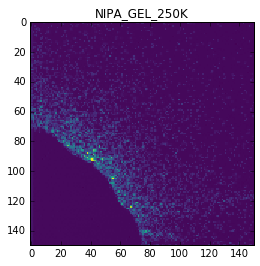

In [7]:
# it would be great to have a link to what this multi-tau scheme is!
num_levels = 7
num_bufs = 8

# load the data
img_stack = np.load("/Volumes/Data/All_NSLS2/scikit-beam-examples/demos/time_correlation/100_500_NIPA_GEL.npy")
fig, ax = plt.subplots()
# plot the first image to make sure the data loaded correctly
ax.imshow(img_stack[0], cmap='viridis', interpolation='nearest')
ax.set_title("NIPA_GEL_250K")
None

In [3]:
#define the ROIs
roi_start = 65 # in pixels
roi_width = 9 # in pixels
roi_spacing = (5.0, 4.0)
x_center = 7. # in pixels
y_center = (129.) # in pixels
num_rings = 3

# get the edges of the rings
edges = roi.ring_edges(roi_start, width=roi_width, 
                       spacing=roi_spacing, num_rings=num_rings)

# get the label array from the ring shaped 3 region of interests(ROI's)
labeled_roi_array = roi.rings(
    edges, (y_center, x_center), img_stack.shape[1:])

def overlay_rois(ax, image, label_array):
    """
    This will plot the reqiured roi's on the image
    """
    tmp = np.array(label_array, dtype='float')
    tmp[label_array==0] = np.nan
    
    im_data = ax.imshow(image, interpolation='none', norm=LogNorm(), cmap='viridis')
    im_overlay = ax.imshow(tmp, cmap='Paired', 
                   interpolation='nearest', alpha=.5,)
    
    return im_data, im_overlay

fig, ax = plt.subplots()
plt.title("NIPA_GEL_250K")
im_data, im_overlay = overlay_rois(ax, img_stack[0], labeled_roi_array)
plt.show()

NameError: name 'roi' is not defined

In [9]:
def _one_time_process(buf, G, past_intensity, future_intensity,
                      label_array, num_bufs, num_pixels, img_per_level,
                      level, buf_no, norm, lev_len):
    """Reference implementation of the inner loop of multi-tau one time
    correlation

    This helper function calculates G, past_intensity_norm and
    future_intensity_norm at each level, symmetric normalization is used.

    .. warning :: This modifies inputs in place.

    Parameters
    ----------
    buf : array
        image data array to use for correlation
    G : array
        matrix of auto-correlation function without normalizations
    past_intensity_norm : array
        matrix of past intensity normalizations
    future_intensity_norm : array
        matrix of future intensity normalizations
    label_array : array
        labeled array where all nonzero values are ROIs
    num_bufs : int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain ROI's
        ROI's, dimensions are : [number of ROI's]X1
    img_per_level : array
        to track how many images processed in each level
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number
    norm : dict
        to track bad images
    lev_len : array
        length of each level

    Notes
    -----
    .. math::
        G = <I(\tau)I(\tau + delay)>
    .. math::
        past_intensity_norm = <I(\tau)>
    .. math::
        future_intensity_norm = <I(\tau + delay)>
    """
    img_per_level[level] += 1
    # in multi-tau correlation, the subsequent levels have half as many
    # buffers as the first
    i_min = num_bufs // 2 if level else 0
    #if img_per_level[level]<2:
    value = img_per_level[level]
    num_proc_to_use = multiprocessing.cpu_count()
    p = Pool(processes=num_proc_to_use)
    results = np.zeros([num_proc_to_use], np.object)
    for i in range(num_proc_to_use):
        results[i] = p.starmap(multi_process, [(buf, G, past_intensity, future_intensity,
                                                            label_array, num_bufs, num_pixels, img_per_level,
                                                          level, buf_no, norm, lev_len, i_min, value)])
                                        
    p.close()
    p.join()
    #print ("number of process", num_proc_to_use)
    
    #G = np.array(np.array(results[0])[0][0]+ np.array(results[1])[0][0] +
    #            np.array(results[2])[0][0] + np.array(results[3])[0][0])
    #past_intensity = np.array(np.array(results[0])[0][1]+ np.array(results[1])[0][1] +
    #            np.array(results[2])[0][1] + np.array(results[3])[0][1])
    #future_intensity = np.array(np.array(results[0])[0][2]+ np.array(results[1])[0][2] +
    #            np.array(results[2])[0][2] + np.array(results[3])[0][2])
    norm = np.array(results[3])[0][3]
    #G1 = G_results[0]+ G_results[1] + G_results[2]
    #print ("G", G)
    #print ("past", past_intensity)
    for i in range(G.shape[0]):
        G[i] = (np.array(results[0])[0][0][i] + np.array(results[1])[0][0][i] + np.array(results[2])[0][0][i] 
               + np.array(results[3])[0][0][i])
        past_intensity[i] = (np.array(results[0])[0][1][i] + np.array(results[1])[0][1][i] + np.array(results[2])[0][1][i] 
               + np.array(results[3])[0][1][i])
        future_intensity[i] = (np.array(results[0])[0][2][i] + np.array(results[1])[0][2][i]
                              + np.array(results[2])[0][2][i] + np.array(results[3])[0][2][i])
    return #G, past_intensity, future_intensity, norm, img_per_level  # modifies arguments in place!

In [10]:
def _inner_function(buf, G, past_intensity_norm, future_intensity_norm,
                    label_array, num_bufs, num_pixels, img_per_level,
                    level, buf_no, norm, lev_len, i_min, value):
    p = Pool(processes=3)
    results1, results2, results3 = p.starmap(multi_process, [(buf, G, past_intensity_norm, future_intensity_norm,
                                         label_array, num_bufs, num_pixels, img_per_level,
                                         level, buf_no, norm, lev_len, i_min, value),
                                        (buf, G, past_intensity_norm, future_intensity_norm,
                                        label_array, num_bufs, num_pixels, img_per_level,
                                        level, buf_no, norm, lev_len, i_min, value),
                                         (buf, G, past_intensity_norm, future_intensity_norm,
                                        label_array, num_bufs, num_pixels, img_per_level,
                                        level, buf_no, norm, lev_len, i_min, value) ])
    p.close()
    p.join()
    print ("1", results1[0])
    print ("2", results2[0])
    G1 = results1[0] + results2[0] + results3[0]
    past_intensity_norm1 = results1[1] + results2[1] + results3[1]
    future_intensity_norm1 = results1[2] + results2[2] + results3[2]
    norm1 = results2[3]
    for w, arr in zip([G1, past_intensity_norm1, future_intensity_norm1, norm1],
                    [G, past_intensity_norm, future_intensity_norm, norm]):
        arr = w
        
    return 
    

In [11]:
def multi_process(buf, G, past_intensity_norm, future_intensity_norm,
                  label_array, num_bufs, num_pixels, img_per_level,
                  level, buf_no, norm, lev_len, i_min, value):
    for i in range(i_min, min(value, num_bufs)):
        # compute the index into the autocorrelation matrix
        t_index = level * num_bufs / 2 + i
        delay_no = (buf_no - i) % num_bufs
        # get the images for correlating
        past_img = buf[level, delay_no]
        future_img = buf[level, buf_no]

        # find the normalization that can work both for bad_images
        #  and good_images
        ind = int(t_index - lev_len[:level].sum())
        normalize = img_per_level[level] - i - norm[level+1][ind]

        # take out the past_ing and future_img created using bad images
        # (bad images are converted to np.nan array)
        if np.isnan(past_img).any() or np.isnan(future_img).any():
            norm[level + 1][ind] += 1
        else:
            for w, arr in zip([past_img*future_img, past_img, future_img],
                              [G, past_intensity_norm, future_intensity_norm]):
                binned = np.bincount(label_array, weights=w)[1:]
                arr[t_index] += ((binned / num_pixels -
                                  arr[t_index]) / normalize)
    return G, past_intensity_norm, future_intensity_norm, norm

In [12]:
#num_levels=1
g2, lag = multi_tau_auto_corr(num_levels, num_bufs, labeled_roi_array, (im for im in img_stack))

/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:70: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages

In [13]:
g2,lag

(array([[              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               nan],
        [              nan,               nan,               n

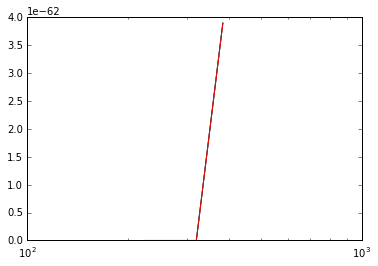

In [14]:
plt.figure()
plt.semilogx(lag, g2)